In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
# import libraries.
import torch
import numpy as np
import datetime
# tf.enable_eager_execution()
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data.sampler import Sampler
from torch.autograd import Variable
from torch.optim.lr_scheduler import MultiplicativeLR, StepLR, LambdaLR
import h5py
import glob
import matplotlib.pyplot as plt
import time
import os
import torch.optim as optim
from natsort import natsorted
print('imported')
# #######################



imported


# Caution! change foldername before execution

In [4]:
# Data_path = 'D:/studies/university/thesis/speech_separation_codes/du16/donesomestuff'
# Data_path = 'D:/hale'
Data_path = '/content/drive/My Drive/journal'
result_path = '/content/drive/My Drive/RL_code/RL_loss'
# Data_path = os.getcwd()[0:-5]
ckpt_folder = '1'

checkpoint_path = os.path.normpath(os.path.join(result_path,'results','checkpoints',ckpt_folder))
if not os.path.exists(checkpoint_path):
    os.makedirs(checkpoint_path)
files = glob.glob(os.path.normpath(os.path.join(checkpoint_path,'*')))
for f in files:
    os.remove(f)
    
loss_path = os.path.normpath(os.path.join(result_path,'results','losses',ckpt_folder))
if not os.path.exists(loss_path):
    os.makedirs(loss_path)
files = glob.glob(os.path.normpath(os.path.join(loss_path,'*')))
for f in files:
    os.remove(f)
    
time_path = os.path.normpath(os.path.join(result_path,'results','times',ckpt_folder))
if not os.path.exists(time_path):
    os.makedirs(time_path)
files = glob.glob(os.path.normpath(os.path.join(time_path,'*')))
for f in files:
    os.remove(f)

    
timestep = 16
batch_size = 32
n_features = 257
epochs_num =100
lr = 0.0001

In [5]:
class Dataset_loader():

    def __init__(self, path, batch_size, timestep, X_, Y_):
        self.write_path = path
        self.batch_size = batch_size
        self.len_data = 0
        self.X_ = X_
        self.Y_ = Y_
        self.timestep = timestep
        # with h5py.File(os.path.normpath(os.path.join(self.write_path))+'.hdf5', "r") as f:
        #     obj = f['X']
        self.len_data = self.X_.shape[0]
        print(self.len_data)
        self.n_features = self.X_.shape[1]
        self.index_arr = np.arange(self.len_data)
        self.index_arr = self.index_arr[0:(len(self.index_arr)//self.timestep)*self.timestep]
        self.index_arr = self.index_arr.reshape((len(self.index_arr)//self.timestep,self.timestep))
        np.random.shuffle(self.index_arr)

    def check_if_left(self):
        if len(self.index_arr)>=self.batch_size:
            return True
        return False

    def get_batch(self):
        self.X_out=self.X_[self.index_arr[0:self.batch_size].reshape(1,self.batch_size*self.timestep)]
        self.Y_out=self.Y_[self.index_arr[0:self.batch_size].reshape(1,self.batch_size*self.timestep)]
        self.index_arr = self.index_arr[self.batch_size:]
        return self.X_out.reshape(self.batch_size,self.timestep,self.n_features),self.Y_out.reshape(self.batch_size,self.timestep,self.n_features)

In [6]:
path = os.path.normpath(os.path.join(Data_path,'h5_files_e','30hdata_2','features','data_30h_loge'))
path_val = os.path.normpath(os.path.join(Data_path,'h5_files_e','devdata_3','features','devdata_30h_loge'))
files = 'data_30h_loge'
files_val = 'devdata_30h_loge'
with h5py.File(path+'.hdf5', "r") as f:
    X = f['X'][:10000]
with h5py.File(path+'.hdf5', "r") as f:
    Y = f['Y'][:10000]
with h5py.File(path_val+'.hdf5', "r") as f:
    X_val = f['X'][:1000]
with h5py.File(path_val+'.hdf5', "r") as f:
    Y_val = f['Y'][:1000]

In [7]:
X.shape

(10000, 257)

In [8]:
load_batch = Dataset_loader( path, batch_size, timestep, X, Y)
load_batch.check_if_left()

10000


True

In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.lstm = nn.LSTM(input_size=n_features,hidden_size=257, num_layers=2, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(514, 257)
    def forward(self, x):
        x, _  = self.lstm(x)
        x = self.fc(x)
        return x
    
net = Net()
net.cuda()
net.train()

Net(
  (lstm): LSTM(257, 257, num_layers=2, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=514, out_features=257, bias=True)
)

In [29]:
class DQN(nn.Module):

    def __init__(self):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(2, 10)
        self.fc2 = nn.Linear(10, 2)
    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        return x
qnet = DQN()
qnet.cuda()
qnet.train()

DQN(
  (fc1): Linear(in_features=2, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=2, bias=True)
)

In [11]:
class DQN_old(nn.Module):

    def __init__(self, h, w, outputs):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(1, 10)
        self.fc2 = nn.Linear(10, 2)
    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        return x

In [12]:
def optim_DQN(r1, r2, w, w1p, w2p, optim_q):
    wlps1 = w[0] + alpha*(r1+(gamma*w1p))
    wlps2 = w[1] + alpha*(r2+(gamma*w2p))
    criterion = nn.MSELoss()
    loss = criterion(wlps1, wlps2)
    optim_q.zero_grad()
    loss.backward()
    optim_q.step()
optim_q = optim.Adam(net.parameters(), lr=lr)

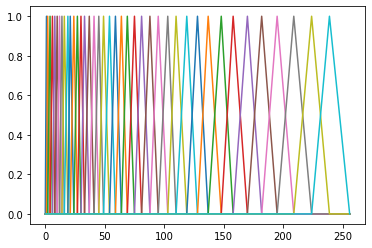

In [13]:
mel = np.loadtxt(os.path.normpath(os.path.join(result_path,'mel40.txt')))
for i in range(40):
    plt.plot(mel[i])
plt.show()

In [23]:
def custom_loss(y_true, y_pred, w1, w2, fbank):
        batch_size = y_true.shape[0]
        n_features = y_true.shape[-1]
        true = torch.sqrt(torch.exp(y_true))
        pred = torch.sqrt(torch.exp(y_pred))
        fbank= fbank.reshape((1,fbank.shape[0],fbank.shape[1]))
        fbank = np.repeat(fbank, batch_size, axis=0)
        fbank = torch.tensor(fbank,device=torch.device('cuda:0'),dtype=torch.float32)
        filtered_true = torch.einsum('mnp,mqp->mnq', true, fbank)
        filtered_pred = torch.einsum('mnp,mqp->mnq', pred, fbank)
#         print(torch.mean(torch.pow(self.filtered_true-self.filtered_pred,2)))
#         print(torch.mean(torch.pow(self.y_true-self.y_pred,2)))
        l1 = torch.mean(torch.pow(filtered_true-filtered_pred,2))*w1
        l2 = torch.mean(torch.pow(y_true-y_pred,2))*w2
        l = (torch.mean(torch.pow(filtered_true-filtered_pred,2))*w1)+(w2*torch.mean(torch.pow(y_true-y_pred,2)))
        # print(type(l1))
        # print(type(l2))
        # print(type(l))
        return l, l1, l2

optimizer = optim.Adam(net.parameters(), lr=lr)

In [24]:
def store_loss(l1,l2, l1_memory, l2_memory):
    memory_size = 50
    if len(l1_memory) <= memory_size:
        l1_memory.append(l1)
        l2_memory.append(l2)
    else:
        l1_memory.insert(0,l1_memory.pop())
        l2_memory.insert(0,l2_memory.pop())
        l1_memory[0] = l1
        l2_memory[0] = l2
    al1 = torch.mean(torch.stack(l1_memory))
    al2 = torch.mean(torch.stack(l2_memory))
    return al1, al2

In [25]:
load_batch.check_if_left()

True

In [26]:

train_loss = np.zeros((epochs_num,1))
val_loss = np.zeros((epochs_num,1))+np.inf
start = time.time()
criterion = custom_loss
running_loss = 0.0
loss_tot = 0.0
v_loss_tot = 0.0
i=0
w_1 = 0.5
w_2 = 0.5
l_1_memory = []
l_2_memory = []
net.train()
load_batch = Dataset_loader(path, batch_size, timestep, X, Y)
load_batch_val = Dataset_loader(path_val, batch_size, timestep, X_val, Y_val)
epoch = 0
while load_batch.check_if_left():
    inputs, labels = load_batch.get_batch()
    inputs=Variable(torch.tensor(inputs).float())
    labels=Variable(torch.tensor(labels).float())
    inputs = inputs.cuda()
    labels = labels.cuda()
    optimizer.zero_grad()
    outputs = net(inputs)
    loss, l_1, l_2 = criterion(outputs, labels, w_1, w_2, mel)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
    loss_tot += loss.item()
    if (i+1) % 10 == 0:   
        print('[epoch %d, minibatch %5d] loss: %.3f' %
              (epoch + 1, i + 1, running_loss / 10))
        running_loss = 0.0
    i = i+1 


10000
1000
[epoch 1, minibatch    10] loss: 81.924


In [27]:
for epoch in range(epochs_num): 
    running_loss = 0.0
    loss_tot = 0.0
    v_loss_tot = 0.0
    i=0
    load_batch = Dataset_loader(path, batch_size, timestep, X, Y)
    load_batch_val = Dataset_loader(path_val, batch_size, timestep, X_val, Y_val)
    w_1 = 0.5
    w_2 = 0.5

    net.train()
    while load_batch.check_if_left():
        
        inputs, labels = load_batch.get_batch()
        
        inputs=Variable(torch.tensor(inputs).float())
        labels=Variable(torch.tensor(labels).float())
        inputs = inputs.cuda()
        labels = labels.cuda()
        
        optimizer.zero_grad()
        outputs = net(inputs)
        criterion = custom_loss
        loss, l_1, l_2 = criterion(outputs, labels, w_1, w_2, mel)
        al_1, al_2 = store_loss(l_1, l_2, l_1_memory, l_2_memory)
        w_1_p, w_2_p = qnet(torch.stack([l_1, l_2]))
        loss_p, l_1_p, l_2_p = criterion(outputs, labels, w_1, w_2, mel)
        r_1 = l_1_p - al_1
        r_2 = l_2_p - al_2
        w_1_p, w_2_p = qnet(l_1, l_2)
        optim_DQN(r_1, r_2, w_1, w_2, w_1_p, w_2_p)
        w_1 = w_p[0]
        w_2 = w_p[1]
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        loss_tot += loss.item()
        if (i+1) % 1000 == 0:   
            print('[epoch %d, minibatch %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 1000))
            running_loss = 0.0
        i = i+1
    train_loss[epoch] = loss_tot/i
    print('epoch %d, train loss: %.3f' %(epoch+1, loss_tot/i))
    net.eval()
    i=0
    while load_batch_val.check_if_left():
        inputs_val, labels_val = load_batch_val.get_batch()
        inputs_val=Variable(torch.tensor(inputs_val).float())
        labels_val=Variable(torch.tensor(labels_val).float())
        inputs_val = inputs_val.cuda()
        labels_val = labels_val.cuda()
        outputs_val = net(inputs_val)
        criterion = custom_losses(outputs_val, labels_val, epoch)
        v_loss = criterion()
        v_loss_tot += v_loss.item()
        i=i+1
    print(optimizer.param_groups[0]['lr'])
#     scheduler.step()
    if (v_loss_tot/i)<np.min(val_loss):
        torch.save(net.state_dict(), os.path.normpath(os.path.join(checkpoint_path,'ckpt_'+str(epoch+1)+'.pth')))
    val_loss[epoch] = v_loss_tot/i
    print('************ epoch %d, val loss: %.3f ************' %(epoch+1, v_loss_tot/i))
print('Finished Training')
stop = time.time()
with open((os.path.normpath(os.path.join(time_path,str(ckpt_folder)+'.txt'))), 'w') as f:
  f.write('%d' % int(stop-start))
np.savetxt(os.path.normpath(os.path.join(loss_path,'train_loss.txt')),train_loss)
np.savetxt(os.path.normpath(os.path.join(loss_path,'val_loss.txt')),val_loss)
model_path = os.path.normpath(os.path.join(Data_path,'results','models',str(ckpt_folder)+'.pth'))
torch.save(net.state_dict(), model_path)
print('Finished saving')

10000
1000


TypeError: ignored

In [28]:
w_p.item()

ModuleAttributeError: ignored